In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import statistics as sts
import lmfit
from lmfit import Model
from scipy.stats import sem

# Linear Fit
def line(x, m, b):
    return x * m + b
gmodel = Model(line)
param1 = gmodel.make_params(m = 1, b = 1)



In [43]:

# Questions
plot = input('Plot?')
save = input('Save?')
f = input('Include linear fit?')

# Variables
split = 'LSB_07'
metals = {'0G_13': 'Pt',
          '0G_14' : 'Al',
          '0G_15' : 'Mo',
          '0G_16' : 'Cr',
        }
measurements = {'Pt' : {},
                'Al' : {},
                'Mo' : {},
                'Cr' : {}
                }

# Folder where the files are
data_path = os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split, 'LCR')
dict = {}

for i in os.listdir(data_path):
    files = os.listdir(os.path.join(data_path, i))
    for j in files:
        data = pd.read_csv(os.path.join(data_path, i, j))
        data.sort_values(by=['DC'], inplace = True)
        dict[j] = (data['DC'], data['Idc'], data['Vds'])####
        x, y = data['Vds'], data['Idc']
        result = gmodel.fit(y, param1, x = x)
        #result = gmodel.fit(dict[j][1], param1, x = dict[j][2])
        resistance = 1 / result.values['m']
        r_square = 1 - result.residual.var() / np.var(dict[j][1])
        measurements[metals[i]][j[:-4]] = (dict[j], resistance, r_square)
        
        if plot == 'y':

            fig, ax = plt.subplots(facecolor = 'white', dpi = 100)
            ax.set_title(metals[i] + ' ' + i + ' ' + j[:-4])
            ax.set_xlabel('Potential Vds (V)')
            ax.set_ylabel('Current Ids (A)')
            ax.scatter(dict[j][2], dict[j][1], s = 1, label = 'Measurement')
            ax.legend(markerscale = 5)

            if save == 'y':
                plt.savefig(os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split,
                            'Plots', i, metals[i] + ' ' + j[:-4]) + '.png', facecolor = 'white',  bbox_inches='tight')

            if f == 'y':
                
                fig, ax = plt.subplots(facecolor = 'white', dpi = 100)
                ax.set_title(metals[i] + ' ' + i + ' ' + j[:-4])
                ax.set_xlabel('Potential Vds (V)')
                ax.set_ylabel('Current Ids (A)')
                ax.scatter(dict[j][2], dict[j][1], s = 1, label = 'Measurement')
                ax.plot(dict[j][2], result.best_fit, alpha = 0.5, label = 'Linear Fit')
                ax.plot([],[], ' ', label = '{:.2f}'.format(resistance) + ' $\Omega$')
                ax.plot([],[], ' ', label = 'r$^2$ = ' + '{:.5f}'.format(r_square))
                ax.legend(markerscale = 5)

                if save == 'y':
                    plt.savefig(os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split,
                            'Plots', i, 'Fit_' + metals[i] + ' ' + j[:-4]) + '.png', facecolor = 'white',  bbox_inches='tight')



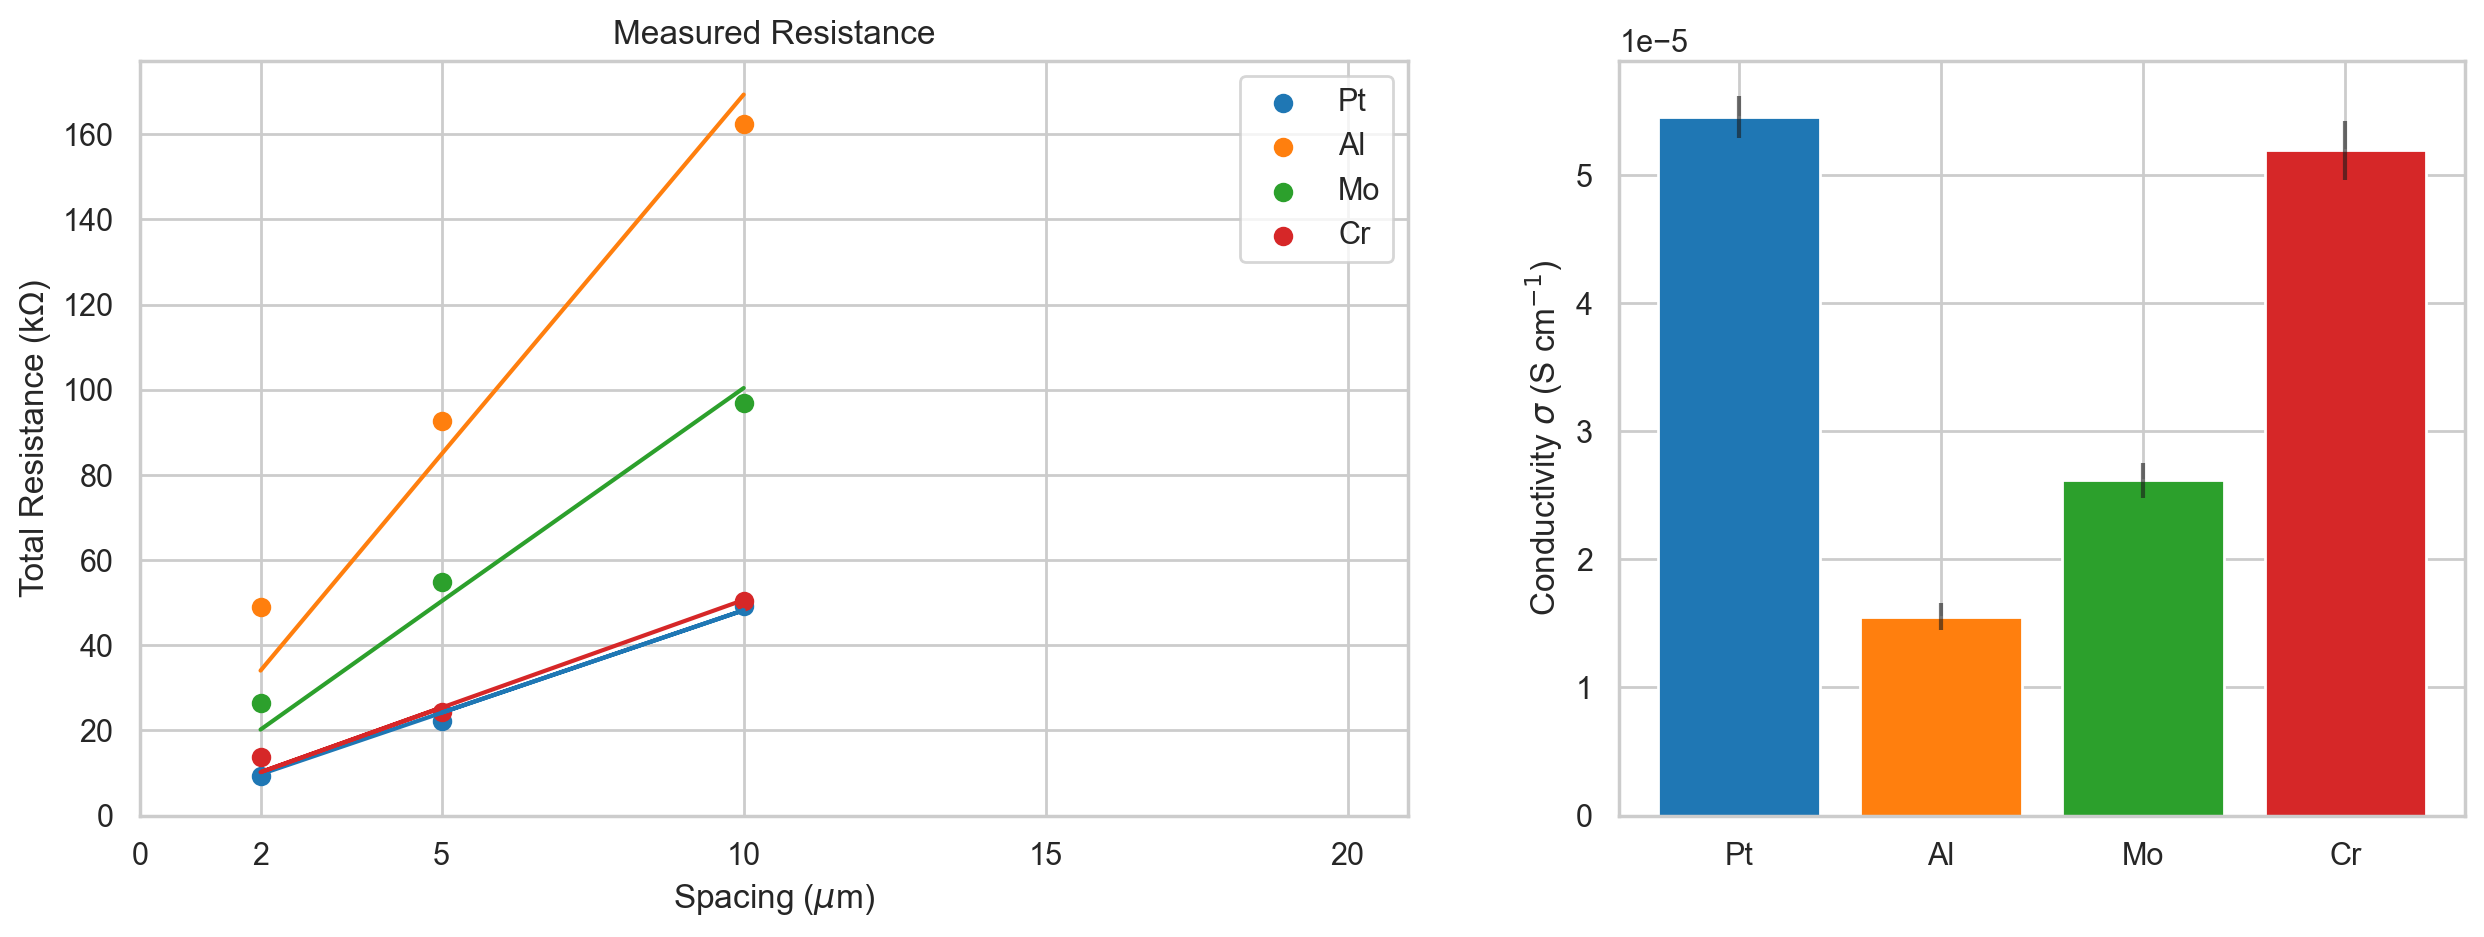

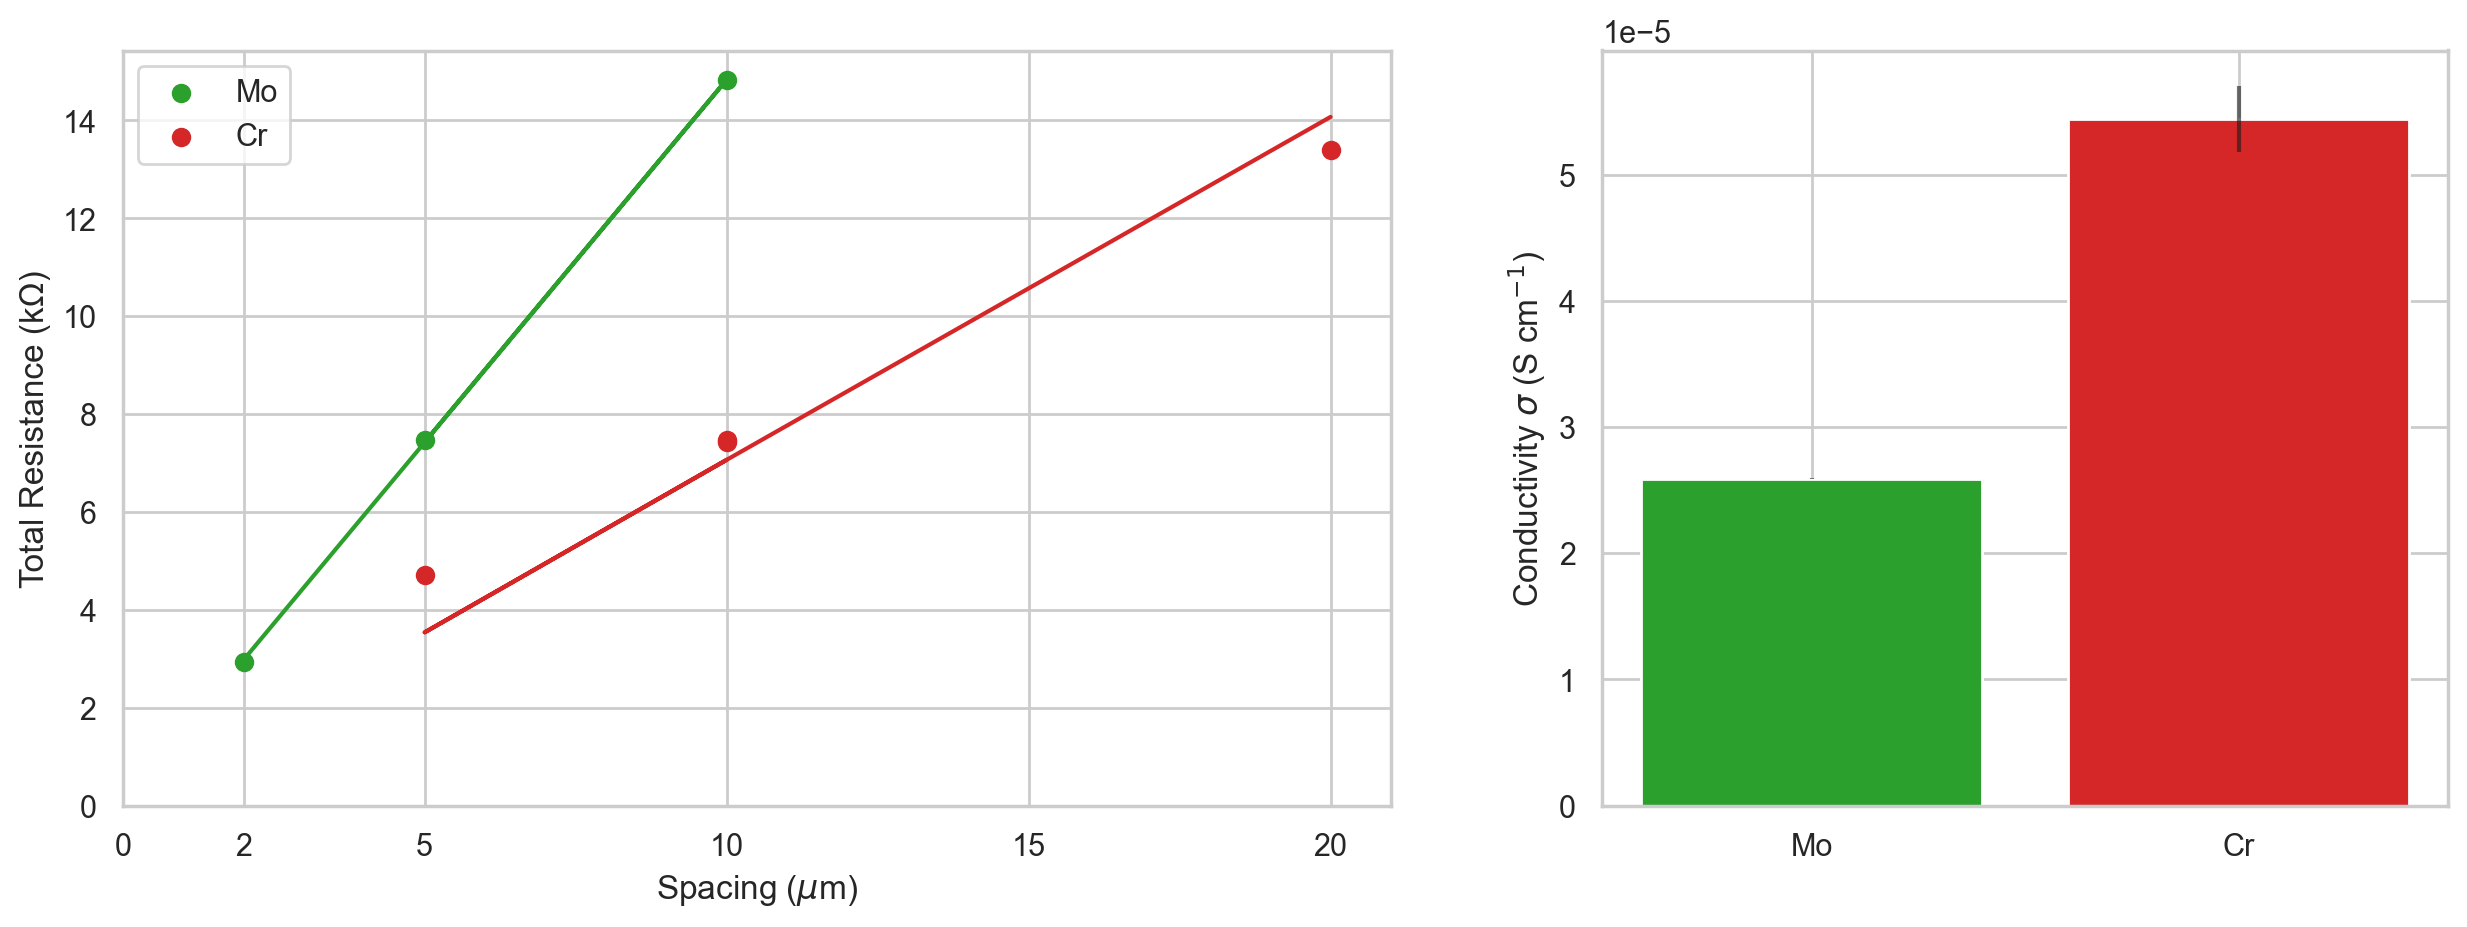

In [44]:
# Resistance as a function of area of test structures
def idea_res(s, sigma, N, W, L, d):
    return s / (sigma * d * (N * W + (N - 1) * (2 * s + L)))

#Initiate model and parameters  
gmodel2 = Model(idea_res)
param2 = gmodel2.make_params(sigma = 5e-9, N = 60, W = 5e-4, L = 3200e-4, d = 0.2e-4)
param2['L'].set(vary = False)
param2['W'].set(vary = False)
param2['N'].set(vary = False)
param2['d'].set(vary = False)

#Plot
plot_path = os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split, 'Plots')
colors = {'Pt' : 'tab:blue',
          'Al' : 'tab:orange',
          'Mo' : 'tab:green',
          'Cr' : 'tab:red'
        }
fig, ax = plt.subplots(dpi = 200,figsize = (15, 5), facecolor = 'white', ncols = 2, gridspec_kw={'width_ratios': [3, 2]})
ax[0].set_xticks(np.array([0, 2, 5, 10, 15, 20]))
ax[0].set_ylabel('Total Resistance (kΩ)')
ax[0].set_xlabel('Spacing ($\mu$m)')
ax[1].set_ylabel('Conductivity $\sigma$ (S cm$^{-1}$)')

q = {} #filter P02, P03 and P04

for i in measurements.keys():
    q[i] = []
    for j in measurements[i].keys():
        r_ohm = measurements[i][j][1]
        if 'P01' in j[3:]:
            q[i].append((2e-4, r_ohm))
        elif 'P02' in j[3:]:
            q[i].append((5e-4, r_ohm))
        elif 'P03' in j[3:]:
            q[i].append((10e-4, r_ohm))
        elif 'P04' in j[3:]:
            q[i].append((20e-4, r_ohm))
            
for i in q.keys():
    x, y = zip(*q[i])
    x = np.array(x)
    y = np.array(y)
    ax[0].scatter(x * 1e4, y / 1000, label = i, c = colors[i])
    fit = gmodel2.fit(y, param2, s = x)
    ax[0].plot(x * 1e4, fit.best_fit / 1000, color = colors[i])
    for name, param in fit.params.items():
            if name == 'sigma':
                ax[1].bar(i, fit.values['sigma'], yerr = param.stderr, color = colors[i], error_kw = {'alpha' : 0.6})
ax[0].set_title('Measured Resistance')
ax[0].set_ylim(0) 
ax[0].set_xlim(0, 21)    
ax[0].legend()
# plt.savefig(os.path.join(plot_path, 'Conductivity_1234') + '.png', facecolor = 'white',  bbox_inches='tight')

# Change of parameters for fit
param2['L'].set(value = 5000e-4)
param2['N'].set(value = 260)

fig, ax = plt.subplots(dpi = 200, figsize = (15, 5), facecolor = 'white', ncols = 2, gridspec_kw={'width_ratios': [3, 2]})
ax[0].set_xticks(np.array([0, 2, 5, 10, 15, 20]))
ax[0].set_ylabel('Total Resistance (kΩ)')
ax[0].set_xlabel('Spacing ($\mu$m)')
ax[1].set_ylabel('Conductivity $\sigma$ (S cm$^{-1}$)')


q = {} #filter P05, P06, P07 and P08

for i in measurements.keys():
    q[i] = []
    for j in measurements[i].keys():
        r_ohm = measurements[i][j][1]
        if 'P05' in j[3:]:
            q[i].append((2e-4, r_ohm))
        elif 'P06' in j[3:]:
            q[i].append((5e-4, r_ohm))
        elif 'P07' in j[3:]:
            q[i].append((10e-4, r_ohm))
        elif 'P08' in j[3:]:
            q[i].append((20e-4, r_ohm))

for i in q.keys():
    if len(q[i]) > 0:
        x, y = zip(*q[i])
        x = np.array(x)
        y = np.array(y)
        ax[0].scatter(x * 1e4, y / 1000, label = i, c = colors[i])
        fit = gmodel2.fit(y, param2, s = x)
        ax[0].plot(x* 1e4 , fit.best_fit / 1000, color = colors[i])
        for name, param in fit.params.items():
            if name == 'sigma':
                ax[1].bar(i, fit.values['sigma'], yerr = param.stderr, color = colors[i], error_kw = {'alpha' : 0.6})
#ax[0].set_title('Measured Resistance')

ax[0].set_xlim(0, 21)
ax[0].set_ylim(0)       
ax[0].legend()
# plt.savefig(os.path.join(plot_path, 'Conductivity_5678') + '.png', facecolor = 'white',  bbox_inches='tight')



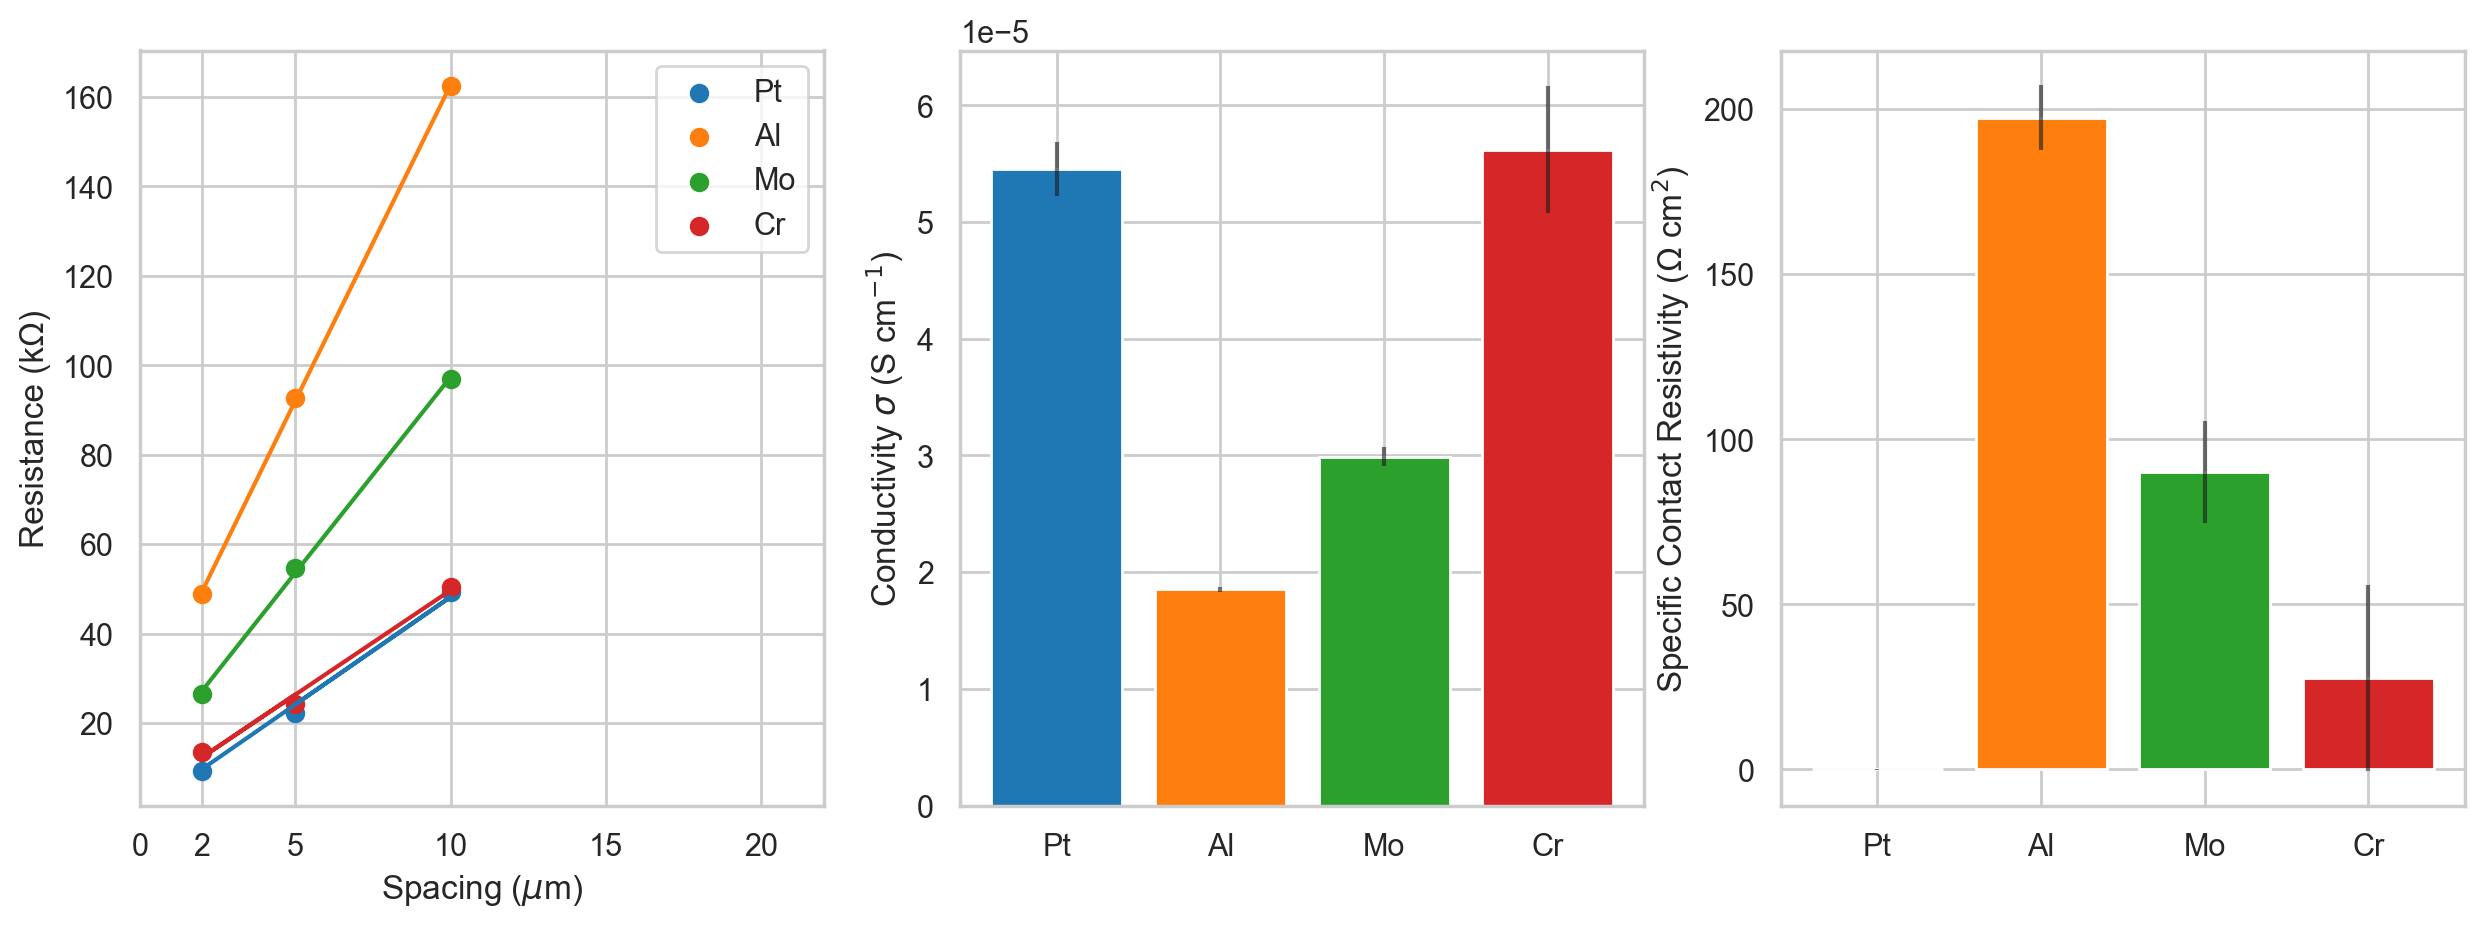

In [45]:
#Lineal fit for contact resistance

def total_r(s, sigma, rho_c, d, n, w, l):
    return ((s / (sigma * d)) + (rho_c / w)) * (1 / (n * w + (n - 1) * (2 * s + l)))
gmodel3 = Model(total_r)
param3 = gmodel3.make_params(sigma = 6e-5, rho_c = 1, n = 60, w = 5e-4, l = 3200e-4, d = 0.2e-4)
param3['d'].set(vary = False)
param3['n'].set(vary = False)
param3['w'].set(vary = False)
param3['l'].set(vary = False)
param3['rho_c'].set(min = 0)
param3['sigma'].set(vary = True)

param1['b'].set(min = 0)

fig, ax = plt.subplots(dpi = 200,figsize = (15, 5), facecolor = 'white', ncols = 3, gridspec_kw={'width_ratios': [2, 2, 2]})
ax[0].set_xticks(np.array([0, 2, 5, 10, 15, 20]))
ax[0].set_ylabel('Resistance (kΩ)')
ax[0].set_xlabel('Spacing ($\mu$m)')
ax[1].set_ylabel('Conductivity $\sigma$ (S cm$^{-1}$)')
ax[2].set_ylabel('Specific Contact Resistivity (Ω cm$^2$)')

q = {} #filter P02, P03 and P04

for i in measurements.keys():
    q[i] = []
    for j in measurements[i].keys():
        r_ohm = measurements[i][j][1]
        if 'P01' in j[3:]:
            q[i].append((2e-4, r_ohm))
        elif 'P02' in j[3:]:
            q[i].append((5e-4, r_ohm))
        elif 'P03' in j[3:]:
            q[i].append((10e-4, r_ohm))
        elif 'P04' in j[3:]:
            q[i].append((20e-4, r_ohm))
            
for i in q.keys():
    # if i == 'Al':
    #     continue
    # elif i == 'Mo':
    #     continue 
    # else:
        x, y = zip(*q[i])
        x = np.array(x)
        y = np.array(y)
        ax[0].scatter(x * 1e4, y / 1000, label = i, c = colors[i])
        fit = gmodel3.fit(y, param3, s = x)
        #fit = gmodel.fit(y, param1, x = x)
        ax[0].plot(x * 1e4, fit.best_fit / 1000, color = colors[i])
        #print(fit.fit_report())
        
        for name, param in fit.params.items():
            if name == 'sigma':
                ax[1].bar(i, fit.values['sigma'], yerr = param.stderr, color = colors[i], error_kw = {'alpha' : 0.6})
            elif name == 'rho_c':
                ax[2].bar(i, fit.values['rho_c'], yerr = param.stderr, color = colors[i], error_kw = {'alpha' : 0.6})
        #     elif name == 'rho_c':
        #         ax[2].bar(i, fit.values['rho_c'], yerr = param.stderr, color = colors[i], error_kw = {'alpha' : 0.6})
#ax[0].set_ylim(0, 350)  
ax[0].set_xlim(0, 22)  
ax[0].legend()



(-10000.0, 30000.0)

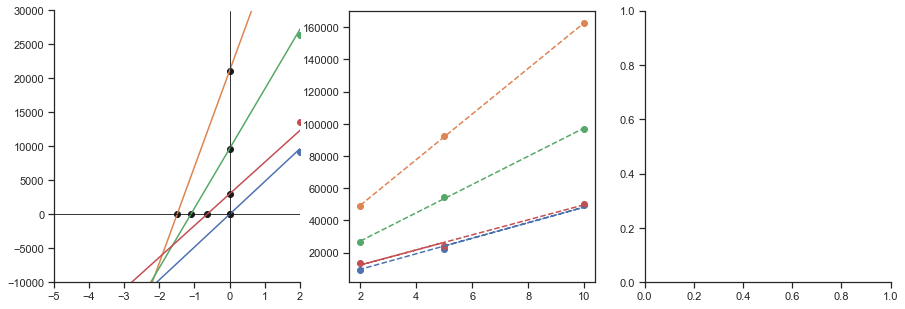

In [46]:
import seaborn
seaborn.set(style='ticks')

def total_resistance(s, r_sheet, L_t, L):
    #return (r_sheet * (s / w)) + (2 *np.sqrt(rho_c * r_sheet) / w )
    return (r_sheet / L) * (s + (2 * L_t))

gmodel4 = Model(total_resistance)
param4 = gmodel4.make_params()
param4['r_sheet'].set(value = 10, min = 0)
param4['L_t'].set(value = 1, min = 0)
param4['L'].set(value = 3200e-4, vary = False)

line = np.array([-5, -2, 0, 2, 5, 10, 15, 20, 25]) * 1e-4


metals = ['Pt', 'Al', 'Mo', 'Cr']
fig, ax = plt.subplots(facecolor = 'white', ncols = 3, figsize = (15, 5))

for i in metals:
    x, y = list(zip(*q[i]))
    x = np.array(x)
    result = gmodel4.fit(y, param4, s = x)
    ax[0].scatter(x * 1e4, y)
    ax[1].plot(x * 1e4, result.best_fit, '--')
    #ax[0].plot(line * 1e4, total_resistance(line, result.best_values['r_sheet'], result.best_values['L_t'], 5e-4))

    for name, param in result.params.items():
        if name == 'r_sheet':
            #continue #ax[1].bar(i,(1 / result.values['r_sheet']))#, yerr = param.stderr)
            ax[1].scatter(x *1e4, y)

        elif name == 'L_t':    
            #ax[2].bar(i, result.values['L_t'])#, yerr = param.stderr)
            #ax[2].bar(i, 2 * result.best_values['L_t'] * 1e4 * result.best_values['r_sheet'] / 3200)
            ax[0].plot(line * 1e4, total_resistance(line, result.best_values['r_sheet'], result.best_values['L_t'], 3200e-4))
            #ax[1].plot(line * 1e4, total_resistance(line, result.best_values['r_sheet'], result.best_values['L_t'], 3200e-4))
            ax[0].axvline(color = 'k', lw = 0.5, alpha = 0.8)
            ax[0].axhline(color = 'k', lw = 0.5, alpha = 0.8)
            ax[0].scatter(-2 * result.best_values['L_t'] * 1e4, 0, color = 'k')
            ax[0].scatter(0, 2 * result.best_values['L_t'] * 1e4 * result.best_values['r_sheet'] / 3200, color = 'k')

seaborn.despine(ax=ax[0])
seaborn.despine(ax = ax[2])

ax[0].set_xlim(-5, 2)
ax[0].set_ylim(-10000, 30000)
# ax[0].set_xticks(np.array([0, 2, 5, 10, 20]))

C:\Users\lopezb41\AppData\Local\Temp\ipykernel_19152\491170063.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)


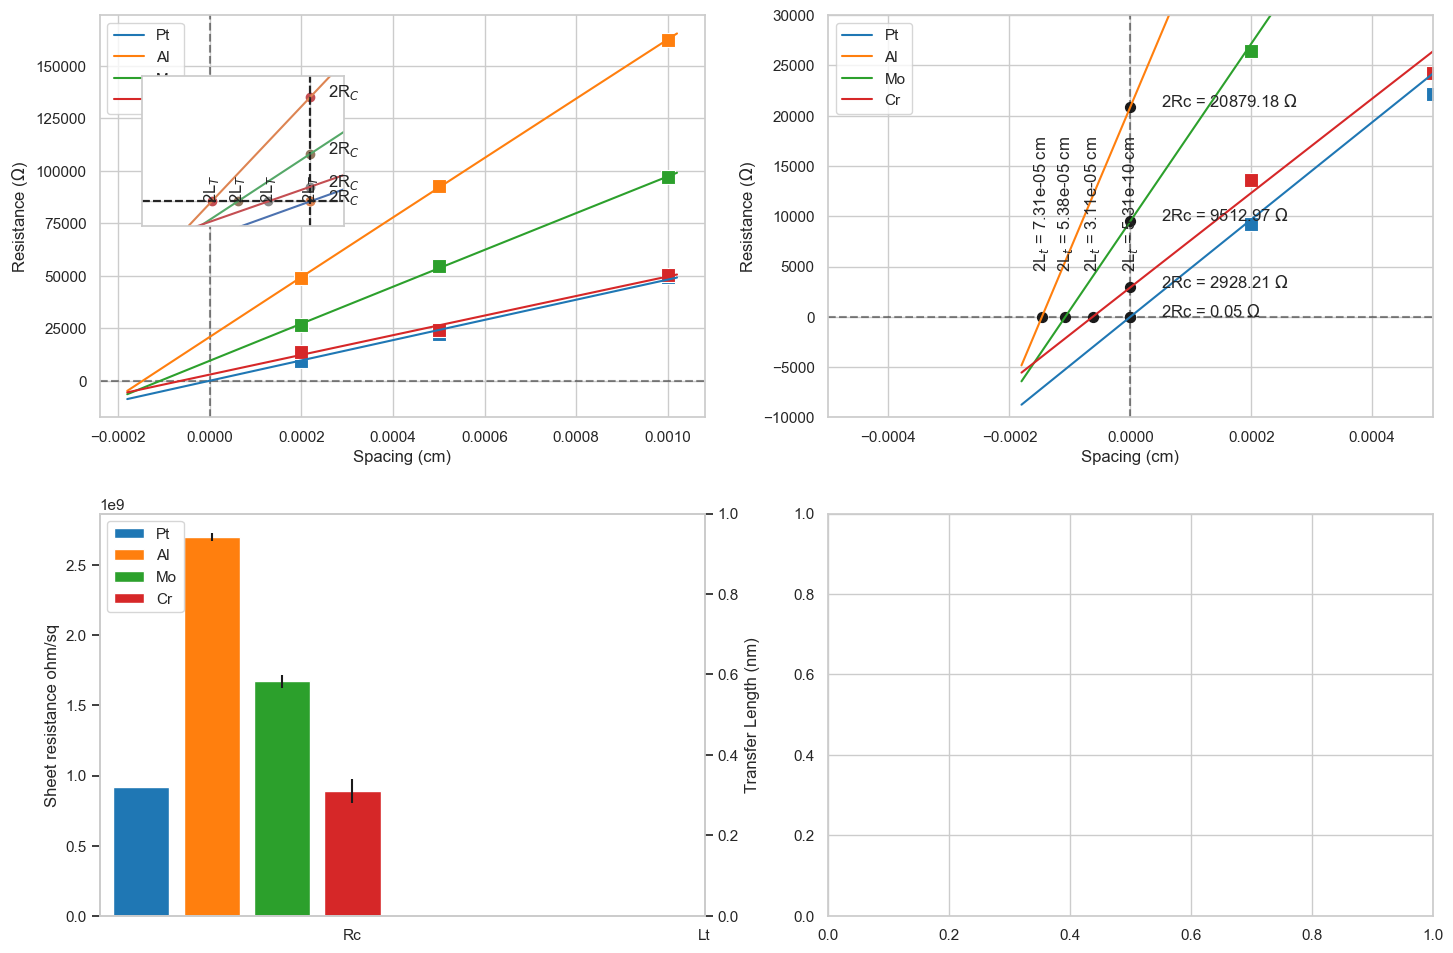

In [56]:
from matplotlib import markers
import seaborn as sns

def r_t(s, r_s, l_t, N, W, L):
    return (r_s * s / (N * W + (N-1) * (2 *s + L))) + (2 * r_s * l_t / (N * W + (N-1) * (2 *s + L)))
w = 60 * 5e-4 + 59 * 3200e-4
gmodel5 = Model(r_t)
param5 = gmodel5.make_params()
param5['r_s'].set(value = 1e8, min = 0)
param5['l_t'].set(value = 1, min = 0)
param5['L'].set(value = 3200e-4, vary = False)
param5['W'].set(value = 5e-4, vary = False)
param5['N'].set(value = 60, vary = False)

sns.set_theme(style="whitegrid")
metals = ['Pt', 'Al', 'Mo', 'Cr']

fig, ax = plt.subplots(2, 2, figsize = (15, 10), dpi = 100)
ax2 = ax[1][0].twinx()
left, bottom, width, height = [0.11, 0.75, 0.135, 0.15]
ax3 = fig.add_axes([left, bottom, width, height])
#fig.suptitle('1 row x 2 columns axes with no data')
ax[0][1].set_xlim(-0.0005, 0.0005)
ax[0][1].set_ylim(-10000, 30000)

ax[0][1].axvline(0, color = 'k', alpha = 0.5, ls = '--')
ax[0][1].axhline(0, color = 'k', alpha = 0.5, ls = '--')
ax[0][0].axvline(0, color = 'k', alpha = 0.5, ls = '--')
ax[0][0].axhline(0, color = 'k', alpha = 0.5, ls = '--')

b = 0
h = 5
count = 0
x_0 = np.arange(-1.8, 11, 1) * 1e-4
for i in metals:
    x, y = np.sort(np.array(list(zip(*q[i]))))
    l = np.array([x, y])
    col = ['Spacing (cm)', 'Resistance ($\Omega$)']
    df = pd.DataFrame(data = l.T, columns = col)
    
    #Scatter data
    sns.scatterplot(data = df, x = col[0], y = col[1], ax = ax[0][0], s = 100, marker = 's', color = colors[i])
    sns.scatterplot(data = df, x = col[0], y = col[1], ax = ax[0][1], s = 100, marker = 's', color = colors[i])
    
    #Fit
    r = gmodel5.fit(y, param5, s = x)
    line = gmodel5.eval(r.params, s = x_0)
    rc = gmodel5.eval(r.params, s = 0)
    l_t = r.best_values['l_t']
    r_s = r.best_values['r_s']
    rho = rc / 2 * l_t * w
    err_rs = r.params['r_s'].stderr        ####################################

    #Lines 
    sns.lineplot(x = x_0, y = line, label = i, ax = ax[0][0], color = colors[i])
    sns.lineplot(x = x_0, y = line, label = i, ax = ax[0][1], color = colors[i])
    ax3.axvline(0, color = 'k', alpha = 0.5, ls = '--')
    ax3.axhline(0, color = 'k', alpha = 0.5, ls = '--')
    sns.lineplot(x = x_0, y = line, ax = ax3)
    
    #Scatter
    ax[0][1].scatter(0, rc, color = 'k', s = 50)
    ax[0][1].scatter(-2 * l_t,0, color = 'k', s = 50)
    sns.scatterplot(data = df, x = col[0], y = col[1], ax = ax3, s = 100, marker = 's')
    ax3.scatter([-2 * l_t, 0],[0, rc])

    ax3.set_xlim(-0.00025, 0.00005)
    ax3.set_ylim(-5000, 25000)
    ax3.set_xticks([0], [''])#[0, 0.0001, 0.0002],[0,1,2])
    ax3.set_yticks([0], [''])
    ax3.set_xlabel('')#'Spacing (um)')
    ax3.set_ylabel('')

    #Bars
    ax[1][0].bar([b], height = [r_s], color = colors[i], yerr = err_rs , label = i)###############
    #ax2.bar([h], height = l_t * 1e7, color = colors[i])
    #ax[1][1].bar([b], height = rho, color = colors[i])

    ax[1][0].set_ylabel('Sheet resistance ohm/sq') #'Specific Contact Resistance $P_C$ ($\Omega$cm$^2$)')
    ax[1][0].legend(loc = 'upper left')

    ax[1][0].set_xticks([b, h], ['Rc', 'Lt'])
    #ax[1][0].set_ylabel('Contact Resistance ($\Omega$)')
    ax2.set_ylabel('Transfer Length (nm)')
    ax2.grid(False)
    ax[1][0].grid(False)


    #Text
    ax[0][1].text(0.00005, rc, '2Rc = ' + '{:.2f}'.format(rc) + ' $\Omega$', ha = 'left')
    ax[0][1].text(-2 * l_t, 5000, '2L$_t$ = ' + '{:.2e}'.format(l_t) + ' cm', rotation = 'vertical', ha = 'center')
    ax3.text(-2 * l_t, 800, '2L$_T$', rotation = 'vertical', ha = 'center')
    ax3.text(0.00005, rc, '2R$_C$', ha = 'center')
    
    b += 1
    h += 1

    #print(r.fit_report())

fig.tight_layout(pad=2.0)


C1_P01.txt 48918.25910340267 None
C2_P03.txt 162392.91165519864 None



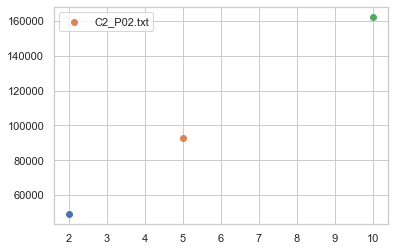

In [48]:
data_path = os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split, 'LCR', '0G_14')
dir = os.listdir(data_path)
dict = {}

for i in dir:
    path = os.path.join(data_path, i)
    data = pd.read_csv(path)
    data.sort_values(by=['DC'], inplace = True)
    x, y = data['Vds'], data['Idc']
    r = gmodel.fit(y, param1, x = x)
    m = r.best_values['m']
    resistance = 1 / m
    if '01' in i:
        plt.scatter(2, resistance)
        print(i, 1/r.params['m'], r.params['m'].stderr)
    elif '02' in i:
        plt.scatter(5, resistance, label = i)
    elif '03' in i:
        plt.scatter(10, resistance)
        print(i, 1/r.params['m'], r.params['m'].stderr)

    # elif '04' in i:
    #     plt.scatter(20, resistance, label = i)   
    
    # plt.plot(x, y)

    


plt.legend()

print('')

